## Classification of Galaxies with Image Data

In [2]:
! pip install astroNN
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow import keras

from keras.models import Sequential
from keras.models import Model
from tensorflow.keras import layers
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from tensorflow.keras import utils

import matplotlib.pyplot as plt

from astroNN.datasets import galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup

2023-03-24 00:37:29.471590: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


In [3]:
#to use unverified ssl:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Loading and Splitting the Data

In [ ]:
images, labels = galaxy10.load_data()

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

features = ['Disk, Face-on, No Spiral', 'Smooth, Completely round', 'Smooth, in-between round', 'Smooth, Cigar shaped', 'Disk, Edge-on, Rounded Bulge', 'Disk, Edge-on, Boxy Bulge', 
            'Disk, Edge-on, No Bulge','Disk, Face-on, Tight Spiral', 'Disk, Face-on, Medium Spiral', 'Disk, Face-on, Loose Spiral']

x_train = x_train / 255.0
x_test = x_test / 255.0

In [49]:
x_train.shape, x_test.shape

((17428, 69, 69, 3), (4357, 69, 69, 3))

## Visualizing Random Images from Dataset

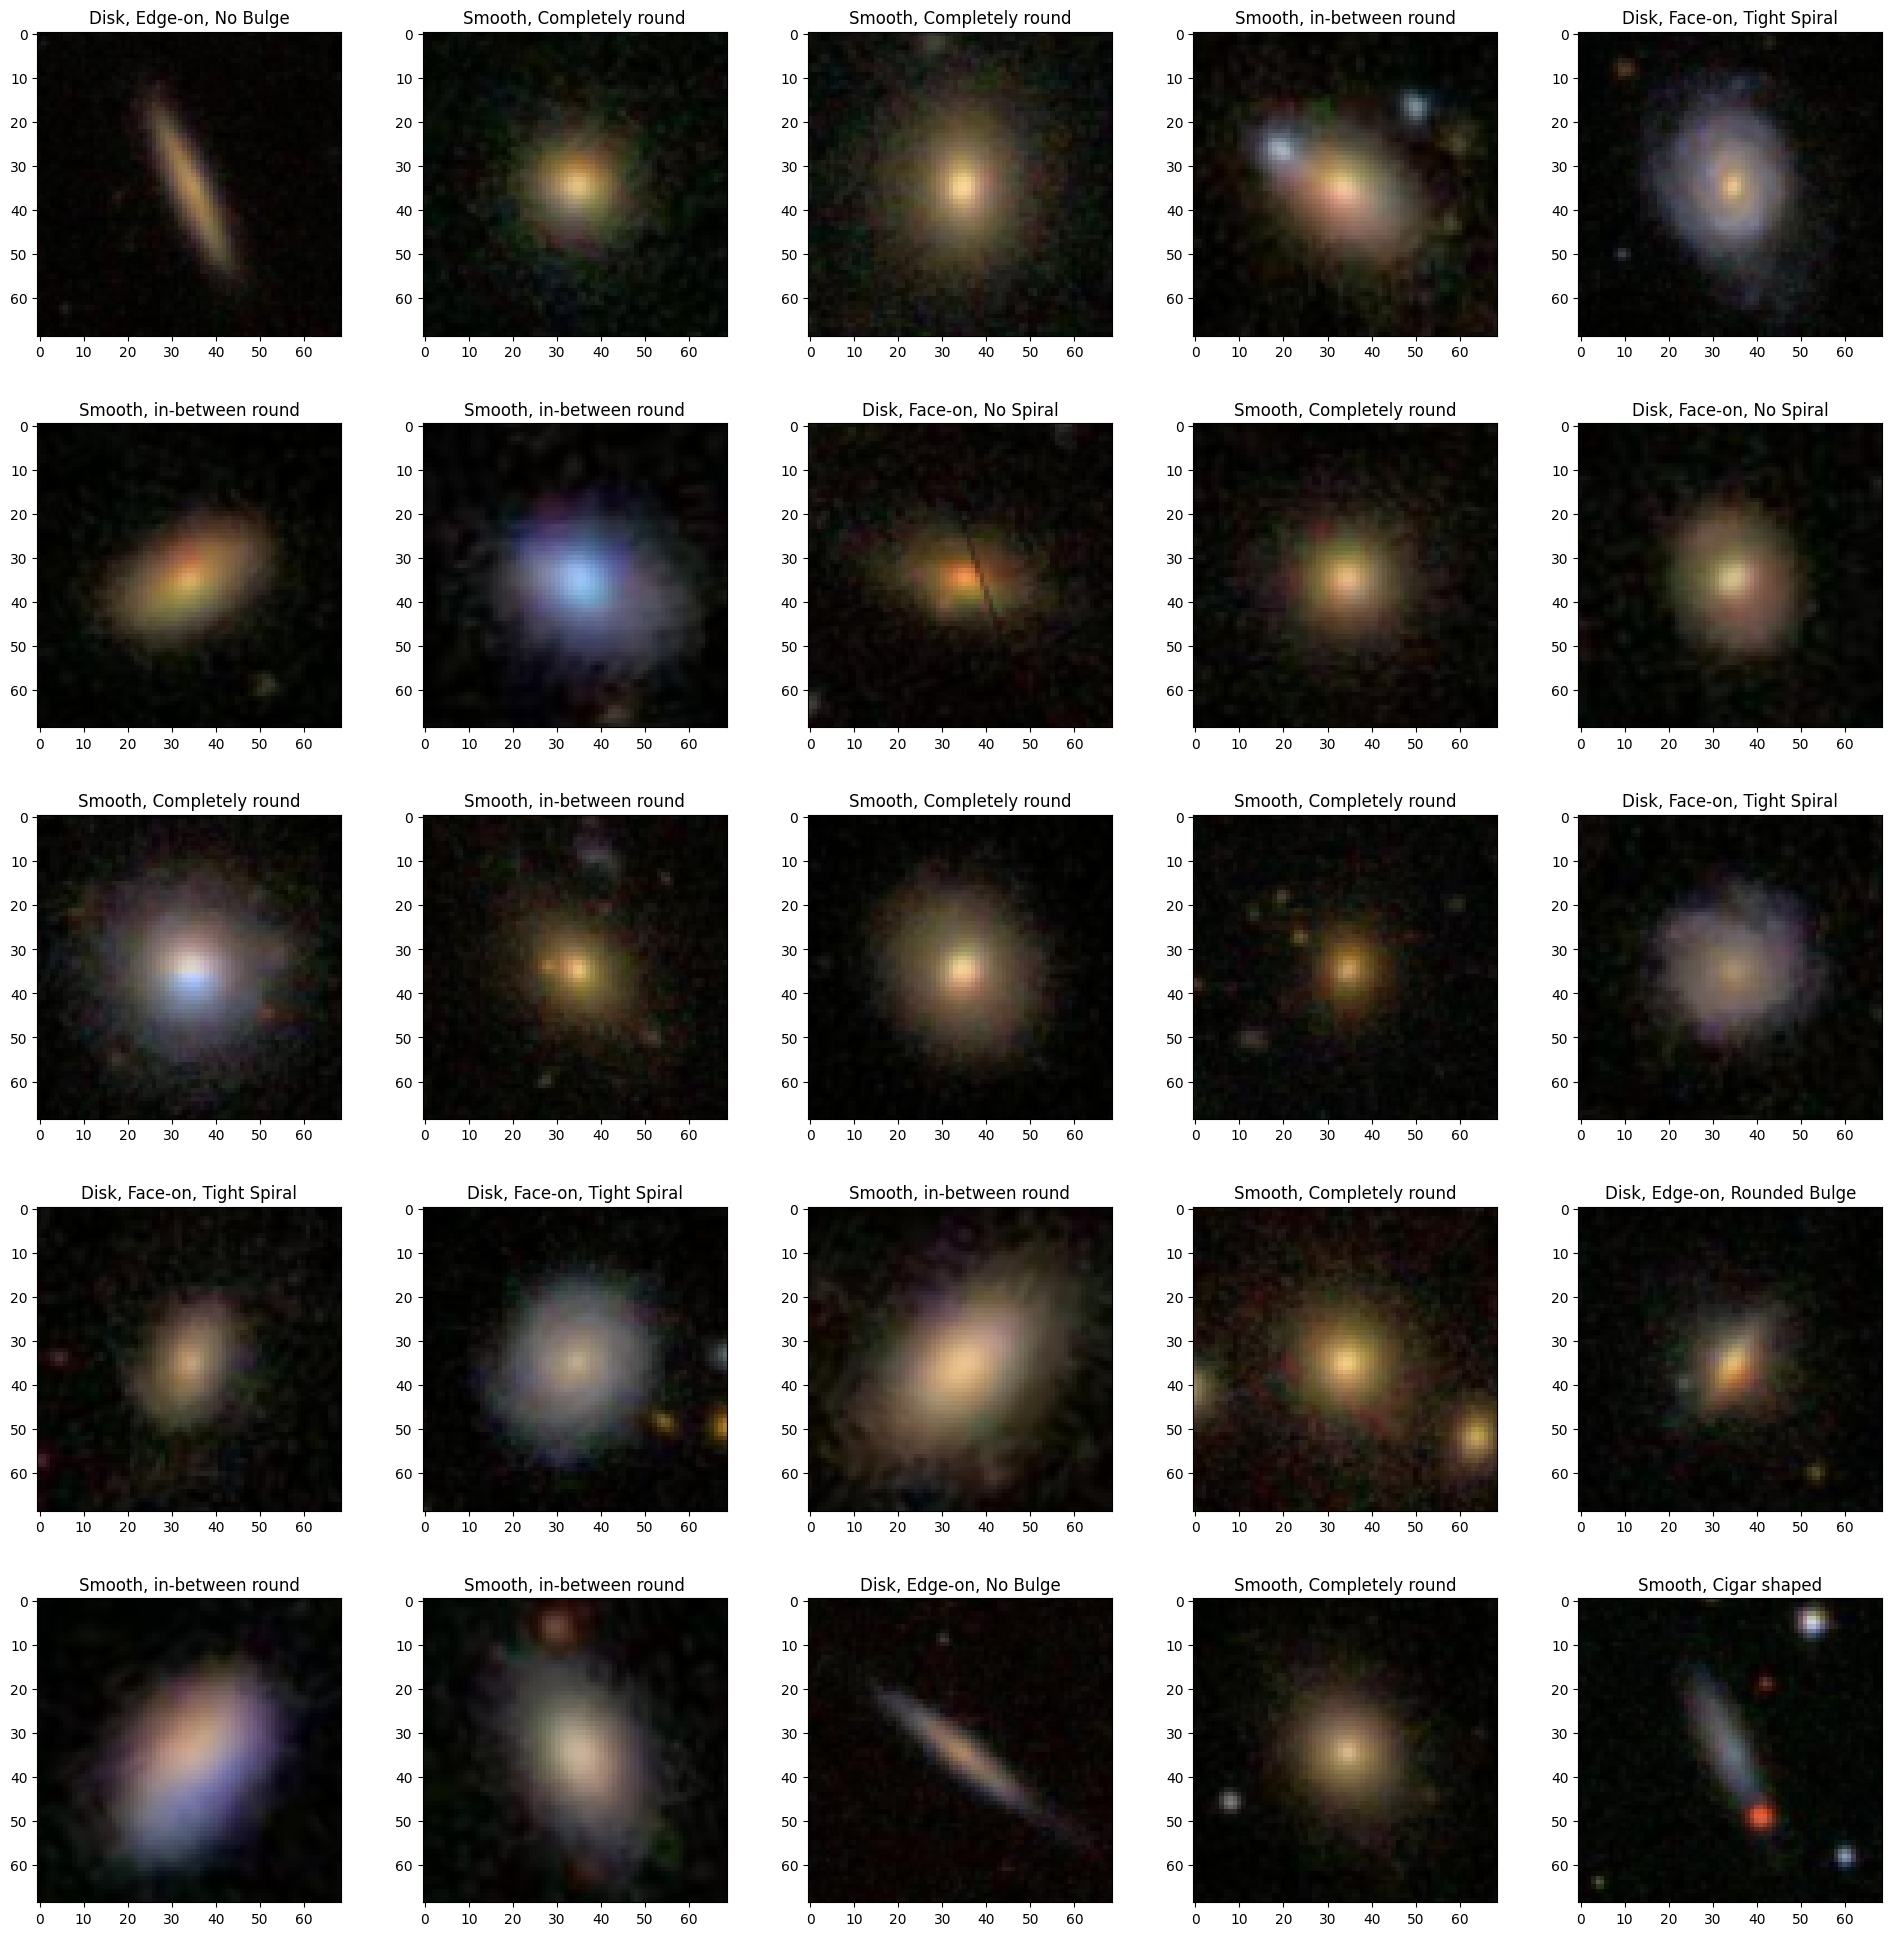

In [6]:
fig = plt.figure(figsize=(20,20)) 

for i in range(25):
    plt.subplot(5,5,i+1)    
    plt.imshow(x_train[i])
    plt.title(features[y_train[i]])
    fig.tight_layout(pad=3.0)
    
plt.show()

## Looking at Class Distribution

In [7]:
df = pd.DataFrame(data=labels)

counts = df.value_counts().sort_index()
print(counts)

0    3461
1    6997
2    6292
3     349
4    1534
5      17
6     589
7    1121
8     906
9     519
dtype: int64


/var/folders/5z/5dn6b41s58nf2nbwff4f5zv80000gn/T/ipykernel_55242/139427031.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


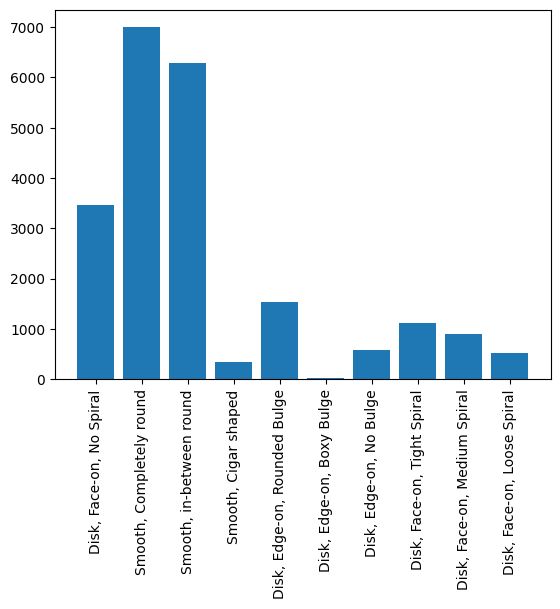

In [8]:
def class_distribution(x, y, labels):
    fig, ax = plt.subplots()
    ax.bar(x, y)
    ax.set_xticklabels(labels, rotation=90)
    plt.show()
    
class_distribution(features, counts, features)

## Trying the LeNet-5 architecture

The LeNet-5 architecture consists of two sets of convolutional layers followed by max-pooling layers, and then fully connected layers. This model is created using Sequential() from Keras. 

The first layer added is a Conv2D layer with 6 filters, a kernel size of (5,5), a stride of (1,1), and a hyperbolic tangent activation function with the input shape set to (69,69,3), meaning the input images are 69x69 pixels using 3 color channels (RGB). The output of the first Conv2D layer is then passed through an AveragePooling2D layer with a pool size of (2,2) and a stride of (2,2). This is repeated with another set of Conv2D and AveragePooling2D layers with 16 filters in the second Conv2D layer.

The output of the second pooling layer is flattened and passed through three fully connected Dense layers with 120, 84, and 10 units respectively. The activation function used in these layers is hyperbolic tangent for all except the last layer, which uses the softmax activation function to output the probabilities of the 10 classes.

The model is then compiled using the Adam optimizer with a learning rate of 0.001 and sparse categorical cross-entropy loss function. It is trained on the x_train and y_train datasets for 20 epochs using the fit() method. A ReduceLROnPlateau callback is added to reduce the learning rate when the accuracy plateaus. This callback monitors the accuracy metric, and if it does not improve by at least 0.01 for 1 epoch, the learning rate is multiplied by a factor of 0.001.

The model achieved ~73% accuracy.

In [11]:
model2 = Sequential()

# LeNet-5 conv-net architecture
model2.add(Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), activation='tanh', input_shape=(69,69,3)))
model2.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))
model2.add(Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), activation='tanh'))
model2.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model2.add(Flatten())
model2.add(Dense(units=120, activation='tanh'))
model2.add(Dense(units=84, activation='tanh'))
model2.add(Dense(units=10, activation='softmax'))

model_optimizer = Adam(lr=0.001)

reduceLR = ReduceLROnPlateau(monitor='accuracy', factor=.001, patience=1, min_delta=0.01, mode="auto")

model2.compile(optimizer=model_optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
model2.fit(x_train, y_train, epochs=20, callbacks=[reduceLR])

/opt/miniconda3/lib/python3.9/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
545/545 [==============================] - 42s 74ms/step - loss: 1.2660 - accuracy: 0.5190 - lr: 0.0010
Epoch 2/20
545/545 [==============================] - 46s 84ms/step - loss: 0.8856 - accuracy: 0.6819 - lr: 0.0010
Epoch 3/20
545/545 [==============================] - 42s 78ms/step - loss: 0.7661 - accuracy: 0.7141 - lr: 0.0010
Epoch 4/20
545/545 [==============================] - 40s 74ms/step - loss: 0.6901 - accuracy: 0.7474 - lr: 0.0010
Epoch 5/20
545/545 [==============================] - 45s 83ms/step - loss: 0.6121 - accuracy: 0.7750 - lr: 0.0010
Epoch 6/20
545/545 [==============================] - 40s 74ms/step - loss: 0.5535 - accuracy: 0.7981 - lr: 0.0010
Epoch 7/20
545/545 [==============================] - 42s 77ms/step - loss: 0.4838 - accuracy: 0.8220 - lr: 0.0010
Epoch 8/20
545/545 [==============================] - 42s 77ms/step - loss: 0.4234 - accuracy: 0.8487 - lr: 0.0010
Epoch 9/20
545/545 [==============================] - 41s 75ms/step - loss: 0.36

In [16]:
predict2 = model2.predict(x_test).argmax(axis=1)
print(classification_report(y_test, predict2))
accuracy_score(y_test,predict2)

137/137 [==============================] - 8s 54ms/step
              precision    recall  f1-score   support

           0       0.50      0.45      0.47       695
           1       0.85      0.90      0.87      1406
           2       0.81      0.82      0.81      1253
           3       0.43      0.46      0.45        63
           4       0.79      0.78      0.79       311
           5       0.00      0.00      0.00         3
           6       0.70      0.76      0.73       112
           7       0.48      0.42      0.45       248
           8       0.41      0.40      0.40       164
           9       0.45      0.45      0.45       102

    accuracy                           0.73      4357
   macro avg       0.54      0.54      0.54      4357
weighted avg       0.72      0.73      0.72      4357



/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7289419325223778

## Building Own CNN

This architecture contains a series of convolutional layers with ReLU activation, followed by max pooling layers, and then fully connected (dense) layers, ending with a final dense layer with a softmax activation function that enables the input image to be classified into one of the 10 classifications. In fact, unlike the LeNet-5 architecture, hyperbolic tangent activation and average pooling are not used. Continuing, the following are used: adam optimizer, sparse categorical cross-entropy loss function, and accuracy metric. The code employs an 'ImageDataGenerator' to create batches of image data for both training and validation purposes. By using the 'rescale' parameter, the pixel values of input images are normalized. Additionally, the 'validation_split' parameter determines the fraction of input data to be used for validation. 'train_generator' and 'val_generator' are generated using the 'flow()' method of the 'ImageDataGenerator' to obtain batches of training and validation data, respectively. The 'subset' parameter specifies whether the generator should generate training or validation data. Lastly, the 'model.fit()' method is called to train the model for 10 epochs, using the training data produced by 'train_generator'. At the end of each epoch, the 'validation_data' parameter is used to evaluate the model's performance on the validation data. The 'history' object that is returned by 'model.fit()' includes information about the training history, such as the model's loss and accuracy for each epoch. The model achieved ~88% accuracy.

In [39]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(69,69,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

datagenerator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagenerator.flow(images, labels, batch_size=32, subset='training')

val_generator = datagenerator.flow(images, labels, batch_size=32, subset='validation')

history = model.fit(train_generator, epochs=10, validation_data=val_generator)


Epoch 1/10


2023-03-25 02:24:38.869769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


545/545 [==============================] - ETA: 0s - loss: 1.3064 - accuracy: 0.4714

2023-03-25 02:26:00.292498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


545/545 [==============================] - 87s 154ms/step - loss: 1.3064 - accuracy: 0.4714 - val_loss: 1.0065 - val_accuracy: 0.6332
Epoch 2/10
545/545 [==============================] - 79s 144ms/step - loss: 0.8915 - accuracy: 0.6657 - val_loss: 0.7258 - val_accuracy: 0.7439
Epoch 3/10
545/545 [==============================] - 79s 144ms/step - loss: 0.7323 - accuracy: 0.7325 - val_loss: 0.6587 - val_accuracy: 0.7597
Epoch 4/10
545/545 [==============================] - 77s 141ms/step - loss: 0.6275 - accuracy: 0.7695 - val_loss: 0.6681 - val_accuracy: 0.7673
Epoch 5/10
545/545 [==============================] - 80s 146ms/step - loss: 0.5749 - accuracy: 0.7902 - val_loss: 0.6114 - val_accuracy: 0.7815
Epoch 6/10
545/545 [==============================] - 80s 146ms/step - loss: 0.5184 - accuracy: 0.8086 - val_loss: 0.6908 - val_accuracy: 0.7510
Epoch 7/10
545/545 [==============================] - 90s 165ms/step - loss: 0.4722 - accuracy: 0.8272 - val_loss: 0.5705 - val_accuracy: 0.7

In [41]:
predict = model.predict(x_test).argmax(axis=1)
print(classification_report(y_test, predict))
accuracy_score(y_test,predict)

137/137 [==============================] - 6s 46ms/step
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       655
           1       0.93      0.97      0.95      1404
           2       0.93      0.91      0.92      1278
           3       0.85      0.76      0.81        68
           4       0.92      0.94      0.93       301
           5       1.00      0.25      0.40         4
           6       0.93      0.91      0.92       108
           7       0.73      0.72      0.72       218
           8       0.75      0.79      0.77       203
           9       0.79      0.85      0.82       118

    accuracy                           0.88      4357
   macro avg       0.86      0.78      0.79      4357
weighted avg       0.88      0.88      0.88      4357



0.8778976359880651

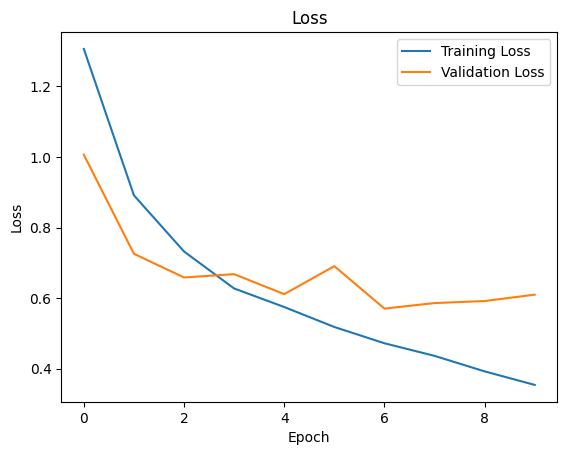

In [44]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

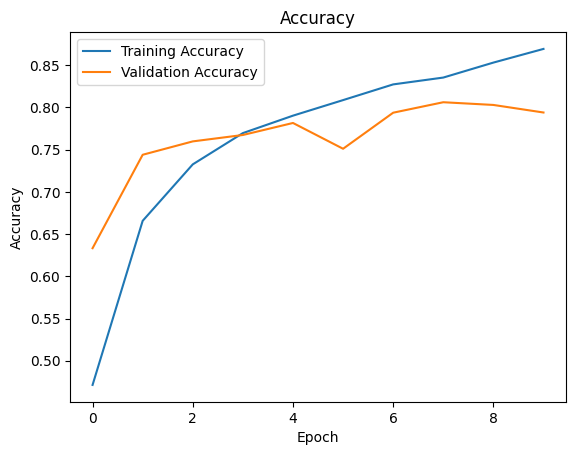

In [45]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## More Complex CNN Architecture

In an effort to optimize the architecture, this attempt added a myriad of methods to observe if more additions to an architecture can make a positive difference in accuracy and results. This architecture consists of multiple convolutional layers with batch normalization, max pooling, and dense layers with dropout. There is also a learning rate scheduler, which determines the learning rate of the optimizer during training. The scheduler reduces the learning rate after a certain number of epochs to improve model convergence. It also creates an image data generator using the 'ImageDataGenerator' function from Keras, which generates augmented images for training the model. Moreover, the training and validation data are also split where 20% of the data is used for validation. The model is ultimately trained using the fit function with the training and validation data generators, along with a few callback functions that are included to help improve the training process. Early stopping is incorporated to stop training in the case where validation loss stops improving after 3 epochs, and reduce learning rate on plateau is used to reduce the learning rate by a factor of 0.2 in the instace where validation loss stops improving after 2 epochs. The model achieved ~86% accuracy.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the CNN architecture
model3 = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(69,69,3)),
    layers.BatchNormalization(), # batch norm
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(), # batch norm
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(), # batch norm
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(), # batch norm
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25), # dropout .25
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Compile the model
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Create image data generator
datagenerator3 = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.1, 
    zoom_range=0.1, 
    horizontal_flip=True
)

# Create training generator
train_generator = datagenerator3.flow(images, labels, batch_size=64, subset='training')

# Create validation generator
valid_gen = datagenerator3.flow(images, labels, batch_size=64, subset='validation')

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define learning rate scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Define reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Train the model
history = model3.fit(train_generator, epochs=20, validation_data=valid_gen, callbacks=[early_stop, lr_scheduler, reduce_lr])

2023-03-24 14:44:56.159261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/20
273/273 [==============================] - ETA: 0s - loss: 1.4069 - accuracy: 0.4377

2023-03-24 14:48:08.853781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


273/273 [==============================] - 207s 743ms/step - loss: 1.4069 - accuracy: 0.4377 - val_loss: 3.3402 - val_accuracy: 0.3300 - lr: 0.0010
Epoch 2/20
273/273 [==============================] - 192s 701ms/step - loss: 1.1920 - accuracy: 0.5216 - val_loss: 1.5359 - val_accuracy: 0.4349 - lr: 0.0010
Epoch 3/20
273/273 [==============================] - 1108s 4s/step - loss: 1.0680 - accuracy: 0.5847 - val_loss: 1.2659 - val_accuracy: 0.5153 - lr: 0.0010
Epoch 4/20
273/273 [==============================] - 200s 731ms/step - loss: 0.9381 - accuracy: 0.6429 - val_loss: 1.0114 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 5/20
273/273 [==============================] - 193s 708ms/step - loss: 0.8417 - accuracy: 0.6819 - val_loss: 0.9297 - val_accuracy: 0.6564 - lr: 0.0010
Epoch 6/20
273/273 [==============================] - 209s 764ms/step - loss: 0.7689 - accuracy: 0.7141 - val_loss: 0.8413 - val_accuracy: 0.6757 - lr: 9.0484e-04
Epoch 7/20
273/273 [==============================] - 2

## Resources

Data and LeNet: https://towardsdatascience.com/galaxy-multi-image-classification-with-lenet-5-1bc2f66d3cfc